###  i./ii.
See `partition_data()`
### iii.
See `RidgePCA`

In [229]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

svd = lambda x: np.linalg.svd(x, full_matrices=False)
inv = np.linalg.inv

N_EXPERIMENTS = 25


data = pd.read_csv("/Users/IKleisle/Stanford/STATS305A/lprostate.csv").iloc[:, 2:]
data.head()

X, Y = data[[col for col in data.columns if col != 'lpsa']].values, data.lpsa.values

def partition_data(X, Y, **kwargs):
    # (i)
    X_train_unsc, X_test_unsc, Y_train_unsc, Y_test_unsc = train_test_split(X, Y, **kwargs)
    # (ii)
    scaler_x, scaler_y = StandardScaler(), StandardScaler()
    X_train = scaler_x.fit_transform(X_train_unsc)
    Y_train = scaler_y.fit_transform(Y_train_unsc.reshape(-1, 1)).flatten()
    X_test = scaler_x.transform(X_test_unsc)
    Y_test = scaler_y.transform(Y_test_unsc.reshape(-1, 1)).flatten()
    return (
        X_train, 
        Y_train,
        X_test,
        Y_test, 
        scaler_x,
        scaler_y
    )
    
class RidgePCA:
    def __init__(self):
        self.U = None
        self.D = None # \Gamma
        self.V = None
        self.X = None
        self.N = None
        self.Y = None
    
    def init_data(self, X, Y):
        self.X = X
        self.Y = Y
        self.U, self.D, self.V = svd(self.X)
        self.D = np.diag(self.D)
        self.N = self.X.shape[0]

        self.ols_sol = inv(self.X.T@ self.X) @ self.X.T @ self.Y
        self.sigma2 = np.multiply(
            (self.X.shape[0] - self.X.shape[1]) ** (-1),
            (self.X @ self.ols_sol - self.Y).T @ (self.X @ self.ols_sol - self.Y)

        )
        
    def get_optimal_lambda(self):
        self.lambda_opt = []
        self.feature_slice = np.ones(self.D.shape[0])
        for j in range(self.D.shape[0]):
            uj = self.U[:, j]
            if self.sigma2 >= (uj.T @ self.Y) ** 2:
                opt_lam = np.inf
                self.feature_slice[j] = 0
            else:
                opt_lam = (
                    (self.sigma2 * self.D[j, j]**2) /
                    ((uj.T @ self.Y) ** 2 - self.sigma2)
                )
            self.lambda_opt.append(opt_lam)
            
    def fit_optimal_lambda_helper(self):
        self.bhat_lambda = self.V @ self.D @ inv(self.D @ self.D + np.diag(self.lambda_opt)) @ self.U.T @ self.Y
        
    def fit(self, X, Y):
        self.init_data(X, Y)
        self.get_optimal_lambda()
        self.fit_optimal_lambda_helper()
    
    def predict(self, X):
        return X @ self.bhat_lambda

def main():
    experiment_results = []
    lambda_vals = []
    for i in range(N_EXPERIMENTS):
        X_train, Y_train, X_test, Y_test, _, _ = partition_data(X, Y, train_size=.6, random_state=1+i)
        ridge_pca_model = RidgePCA()
        ridge_pca_model.fit(X_train, Y_train)
        yhat_test = ridge_pca_model.predict(X_test)

        lambda_risk = (yhat_test - Y_test).T @ (yhat_test - Y_test) / X_test.shape[0]
        lambda_vals.append(ridge_pca_model.lambda_opt)

        ridge_risks = []
        for i in range(-10, 21):
            tau = 10 ** (i / 10)
            bhat_ridge = np.linalg.inv(X_train.T @ X_train + tau * np.eye(X_train.shape[1])) @ X_train.T @ Y_train
            yhat_ridge = X_test @ bhat_ridge
            tau_risk = (yhat_ridge - Y_test).T @ (yhat_ridge - Y_test) / X_test.shape[0]
            ridge_risks.append(tau_risk)

        experiment_result = lambda_risk, np.array(ridge_risks)
        experiment_results.append(experiment_result)

    risk_deltas = np.vstack([np.array(item[1]) - item[0] for item in experiment_results]).mean(axis=0)

    plt.plot(
        np.log([10 ** (i/10) for i in range(-10, 21)]),
        risk_deltas,
        label="Average Gap"
    )


    plt.xlabel("log tau")
    plt.ylabel("AVG($\hat r_{tau} - \hat r_*$)")
    plt.show()

    for item in experiment_results:
        plt.scatter(
            np.log([10 ** (i/10) for i in range(-10, 21)]),
            np.array(item[1]) - item[0],
            alpha=.4,
            color='red'
        )
    plt.plot(
        np.log([10 ** (i/10) for i in range(-10, 21)]),
        risk_deltas,
        label="AVG($\hat r_{tau} - \hat r_*$)"
    )
    plt.xlabel("log tau")
    plt.ylabel("$\hat r_{tau} - \hat r_*$")
    plt.legend()
    plt.show()
    return lambda_vals

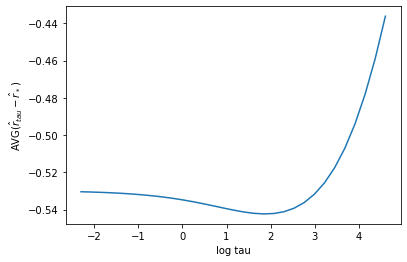

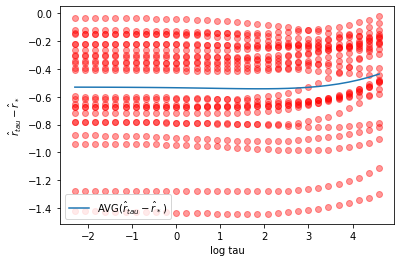

In [230]:
lams = main()

As shown above, the standard ridge outperforms the self-tuned PCA ridge across the board. In general, for values $\tau: \log\tau \sim < 2$, this delta remains fairly constant. However, as $\tau$ increases beyond $\sim 2$, the gap between the estimators closes up, though a considerable delta remains. A couple points of interest:

- Across all explored hyperparameter settings, the simple ridge regression outperforms the PCA. This could speak to the dangers of tuning on the training set (particularly with a training set as small as this one -- about 58-59 rows of data). By performing the $\lambda$ optimization procedure over a small `X_train`, we may be encouraging extreme overfit, in which the $\lambda_j$ procedure selects $\lambda_j^*$'s that are highly specific to that training dataset, and do not reflect importances/relative importances for penalization more generally. This is why we usually do the tuning on a held out set or via CV; such a grid procedure may prove more useful here. 

- As noted above, the gap between the two holdout risks closes as $\tau$ goes to infinity. To understand why this is the case, consider the $\lambda_j^{*}$'s from each of the 25 experiments:

In [233]:
pd.DataFrame(np.vstack(lams), columns=[f"lambda_{i}" for i in range(8)])

,lambda_0,lambda_1,lambda_2,lambda_3,lambda_4,lambda_5,lambda_6,lambda_7
0,2.075030,13.680391,10.813757,inf,inf,inf,4.757229,1.262579
1,4.456288,inf,3.840325,inf,21.959094,12.001395,4.119164,3.174950
2,3.645859,inf,2.098711,inf,63.003464,inf,inf,4.302415
3,2.938309,107.537649,2.603471,inf,7.298878,inf,1.618287,8.295652
4,1.830957,61.255813,2.349264,156.665042,inf,1.582747,4.708052,inf
5,1.742479,20.562487,2.826411,46.179031,inf,inf,8.303882,2.801953
6,3.094163,75.315878,13.682446,5.261965,inf,13.521948,7.146543,2.436895
7,2.814598,42.015536,4.509855,inf,59.530491,22.065902,4.775249,2.146170
8,1.873710,35.132384,4.145971,inf,5.217864,8.855990,40.167470,6.266766
9,2.682305,2900.810879,2.694519,73.702827,inf,7.777980,1.950025,inf


As we see, the $\lambda$ optimization procedure described in (d) often leads to large $\lambda^*_j$ and thus heavy regularization for certain/many coefficients. Hence, as $\tau$ increases and imposes heavier regularization, the two solutions become more similarly regularized and thus more similar. This explains the narrowing of the performance gap. 